In [1]:
#import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *
import matplotlib.pyplot as plt
import face_recognition
from PIL import Image

Using TensorFlow backend.


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

In [8]:
%reload_ext autoreload

In [2]:
!pip install opencv-python

    100% |████████████████████████████████| 26.6MB 1.7MB/s eta 0:00:01


In [4]:
!pip install face_recognition

  Using cached https://files.pythonhosted.org/packages/3f/ed/ad9a28042f373d4633fc8b49109b623597d6f193d3bbbef7780a5ee8eef2/face_recognition-1.2.3-py2.py3-none-any.whl


In [4]:
# Initialize the model
# The model takes images with shape (3, 96, 96) 'channels first' 
K.set_image_data_format('channels_first')
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

In [3]:
import keras
print(keras.__version__)

2.1.6


In [5]:
# using triplets of images, for triplet loss function
# anchor (A): picture of the person
# positive (P): picture of the same person of the anchor image
# negative (N): picture of a different person than the anchor image(person)
# Goal: Individual's encoding should be closer to the positive image and further away from negative image by margin alpha

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # (encoding) distance between the anchor and the positive
    pos_dist = tf.square(tf.subtract(anchor, positive)) 
    # (encoding) distance between the anchor and the negative
    neg_dist = tf.square(tf.subtract(anchor, negative)) 
    # Subtracting the two previous distances and adding an alpha.
    basic_loss = tf.add(tf.reduce_sum(tf.subtract(pos_dist, neg_dist)), alpha)
    # Taking the maximum of basic_loss and 0.0. Summing over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [7]:
# Compile the model
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [8]:
#Function for resizing an image
def pre_process_image(img, image_size):
    """
    Resizes an image into given image_size (height, width, channel)
    
    Arguments:
    img -- original image, array
    image_size -- tuple containing width, height, channel of the image (h, w, c)
    
    Returns:
    img -- resized image
    """
    height, width, channels = image_size
    img = cv2.resize(img, dsize=(height, width))
    return img

In [9]:
# Function for identifying face locations on an image

def find_face_locations(image_path):
    """
    returns the bounding box locations of the faces, image from the path
    
    Arguments:
    image_path -- destination of the original image
    image_size -- tuple containing width and height of the image (h, w)
    
    Returns:
    (top, right, bottom, left), image -- bounding box
    if multiple faces present in the picture returns a list of tuples, 
    image obtained from image_path
    """
    
    # Use face recognition module to detect faces
    image = face_recognition.load_image_file(image_path)
    
    #Test: print("Shape of the image: " + str(image.shape))
    
    face_locations = face_recognition.face_locations(image)
    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location
        print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    return face_locations, image

### Image to embedding

In [11]:
def face_img_to_encoding(image_path, model): 
    """
    returns the embedding vector of the specific image from the path
    
    Arguments:
    image_path -- Destination of the original image
    model -- Inception model instance in Keras
    
    Returns:
    embeddings -- List containing embeddings of the people in the image
    """
    
    # obtain the face locations and the image
    face_locations, image = find_face_locations(image_path)
    
    #initialize the embeddings list
    embeddings = []
    
    #initialize embeddings list
    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location

        # access the actual face itself
        face_image = image[top:bottom, left:right]
        
         # resize the cropped face image
        image_size = (96, 96, 3)
        img = pre_process_image(face_image, image_size)
        
        # pre-process the face image
        img = img[...,::-1]
        img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
        x_train = np.array([img])
        embedding = model.predict_on_batch(x_train)
        embeddings.append(embedding)
        
    return embeddings

In [28]:
# Create a initial database for identifying people
database = {}
database["leonardo dicaprio"] = face_img_to_encoding("images/dicaprio.jpg", FRmodel)
database["brad pitt"] = face_img_to_encoding("images/bradPitt1.jpg", FRmodel)
database["matt damon"] = face_img_to_encoding("images/mattDamon.jpg", FRmodel)
database["robert downey"] = face_img_to_encoding("images/robertdowney.jpg", FRmodel)
database["unknown"] = face_img_to_encoding("images/unknown.jpg", FRmodel)

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
A face is located at pixel location Top: 66, Left: 56, Bottom: 156, Right: 145
A face is located at pixel location Top: 167, Left: 241, Bottom: 390, Right: 464
A face is located at pixel location Top: 82, Left: 24, Bottom: 211, Right: 153
A face is located at pixel location Top: 56, Left: 91, Bottom: 163, Right: 199


A face is located at pixel location Top: 82, Left: 24, Bottom: 211, Right: 153
[array([[ 0.07832187,  0.06682713, -0.04303091,  0.02284247, -0.03672897,
         0.2106066 ,  0.02668497,  0.01187406, -0.01227099, -0.09639597,
         0.1853287 ,  0.06186858,  0.11487298, -0.14900827, -0.11907037,
        -0.10024217, -0.10556376,  0.10556167, -0.17671226,  0.15973037,
         0.13674209, -0.0318465 , -0.03381598,  0.06489028, -0.07579378,
        -0.10407998, -0.09642427, -0.11346978, -0.05311363,  0.07196679,
        -0.00628607, -0.04401463, -0.03909201,  0.1288354 , -0.00685701,
         0.04554148, -0.03900809,  0.00100832, -0.04932544,  0.00891713,
         0.02895395, -0.10911831, -0.07068682,  0.07988145, -0.11212549,
        -0.19839793,  0.08723467,  0.00811219, -0.16606516,  0.1569674 ,
        -0.03991374, -0.06308354, -0.13102695,  0.09509274, -0.00599089,
         0.03171436, -0.13636978,  0.03768923, -0.10310244, -0.06013446,
        -0.07790923,  0.03831953,  0.2322753

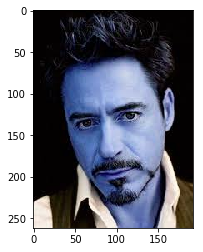

In [27]:
# Test for face_img_to_encoding
embedding = face_img_to_encoding("images/robertdowney.jpg", FRmodel)
img = cv2.imread("images/robertdowney.jpg")
#Visualize the image
plt.imshow(img)
#Visualize the embedding
print(embedding)

### Face Verification

In [18]:
def verify(image_path, identity, database, model):
    # Encodings in the image. 
    encodings = face_img_to_encoding(image_path, FRmodel)
    
    #Loop inside encodings to obtain encoding of each person
    for encoding in encodings:
        # Step 2: Compute distance with identity's image 
        dist = np.linalg.norm(encoding - database[identity])
    
        # Step 3: Match if dist < 0.8
        if dist < 0.8:
            print(str(identity) + ", you are verified")
            match = True
        else:
            print("You're not " + str(identity))
            match = False
        
    return dist, match

In [32]:
verify("images/dicaprio.jpg", "robert downey", database, FRmodel)

A face is located at pixel location Top: 142, Left: 82, Bottom: 409, Right: 349
You're not robert downey


(1.2241077, False)

In [37]:
verify("images/robertdowney4.jpg", "robert downey", database, FRmodel)

A face is located at pixel location Top: 53, Left: 38, Bottom: 182, Right: 167
robert downey, you are verified


(0.63049084, True)